In [1]:
import pickle
import nltk
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load dataframe containing tweets
df_tweets = pd.read_pickle('../Data/Processed/congress_cleaned_processed.pkl')

# Load dataframe with twitter handles
twitter_handles = pd.read_table('../Data/Processed/Twitter_Handles_updated.csv', sep = ',')

In [12]:
# Rename column in order to merge
df_tweets = df_tweets.rename(columns={'user_name': 'twitter_display_name'})
df_Full = pd.merge(df_tweets, twitter_handles, on = 'twitter_display_name')

In [13]:
df_Full.head(10)

,user_id,twitter_display_name,id,created_at,text,retweet,retweet_count,favorite_count,in_reply_to_status_id,in_reply_to_user_id,Twitter,State,Party,Type,Name
0,516880804,Rep. Betty McCollum,824406510558027776,2017-01-26 00:00:03,i will strongly oppose spending a single cent ...,False,47,196,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
1,516880804,Rep. Betty McCollum,824429153151778819,2017-01-26 01:30:01,icymi: my full statement strongly opposing rea...,False,14,48,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
2,516880804,Rep. Betty McCollum,824602802907406336,2017-01-26 13:00:03,tonight: bring your friends and neighbors and ...,False,11,11,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
3,516880804,Rep. Betty McCollum,824712927445917696,2017-01-26 20:17:38,i wrote to president trump today demanding a f...,False,13,55,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
4,516880804,Rep. Betty McCollum,824712963575705600,2017-01-26 20:17:47,.realdonaldtrump's #epa grant freeze and commu...,False,7,21,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
5,516880804,Rep. Betty McCollum,824734163609718786,2017-01-26 21:42:02,i met with cvt_staff today to discuss our shar...,False,13,30,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
6,516880804,Rep. Betty McCollum,824736155908333568,2017-01-26 21:49:57,"torture is illegal, immoral and makes our coun...",False,21,75,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
7,516880804,Rep. Betty McCollum,824760716913737730,2017-01-26 23:27:32,comm e_j_piper and rep bettymccollum04 discuss...,MinnesotaDHS,10,0,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
8,516880804,Rep. Betty McCollum,824777619782647809,2017-01-27 00:34:42,my town hall meeting is live on facebook. foll...,False,4,11,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum
9,516880804,Rep. Betty McCollum,824814944420057093,2017-01-27 03:03:01,thank you to the overflow crowd at tonight's t...,False,6,54,NaN,NaN,BettyMcCollum04,MN,Democrat,Representative,Betty McCollum


Using the dataframe containing all information two lists with tweets are created - one for the republicans and one for the democrats. 

In [14]:
# Making lists of text for republicans and democrats
republican_list = df_Full.loc[df_Full["Party"] == 'Republican', "text"]
democrat_list = df_Full.loc[df_Full["Party"] == 'Democrat', "text"]

Each tweet in the party-specified lists are tokenized into individual strings using the `RegexpTokenizer`. This tokenizer ensures that all punctuation are removed from the texts.

In [15]:
# Tokenize the pages into individual strings and remove all punctuation from the list of tokens
tokenizer = nltk.RegexpTokenizer(r'\w+')

tokens_republican = tokenizer.tokenize(" ".join([i for i in republican_list if i is not None]))
tokens_democrat = tokenizer.tokenize(" ".join([i for i in democrat_list if i is not None]))

Firstly, the TF-TR method will be utilized on all tweets and used for creating word-clouds that characterizes the two parties - Republicans and Democrats. 

The TF-TR method is a way to weighting words in a text in order to retrieve information about the text. The first part is to calculate the Term Frequency (TF) which is given as the number of times a word occurs in a text. The result of calculating the TF gives the most common words in a text but they are not necessarily the most important ones. Thus, the TF information must be weighted which constitutes the second part of this method. In this part of the assignment, the weighting is done using Term Ratios (TR). For the two universes, the TR for a term $t$ with term frequency $TF_t^{(u)}$, where universe $u \in \{m, d\}$ is defined as 

$$w_t^{(m)} = \frac{TF_t^{(m)}}{TF_t^{(d)}+c}, \quad w_t^{(d)} = \frac{TF_t^{(d)}}{TF_t^{(m)}+c},$$
where $c$ is a constant which ensures the avoidance of division by zero. When creating these ratios, it is assumed that the universes have a comparable number of words.

With this, a TF-TR list for each universe can be created where the ranking of term $t$ in universe $u$ is given by $TF_t^{(u)} \times w_t^{(u)}$.

These lists will then be used for creating the so-called TF-TR word-clouds. 

Note: copied from part 2 in assignment 2

For calculating the term frequency of each word in the two lists, the `FreqDist` function is used which outputs a dictionary containing the words as keys and their corresponding values are the number of times each term occurs.

In [16]:
# Term frequency
TF_republican = nltk.FreqDist(tokens_republican)
TF_democrat = nltk.FreqDist(tokens_democrat)

When caluclating the TF-TR the full list of unique words are first found and then the formular can be applied. The TF-TR lists are created as dictionaries where the words are the keys, and the constant $c$ is set to 25. 

In [17]:
# Union the words from both universes
words = set(TF_republican.keys()).union(set(TF_democrat.keys()))

# Initilize dicts
TF_TR_republican = {}
TF_TR_democrat = {}

# Set constant c
c = 25

# Populate dicts
for word in words:
    TF_TR_republican[word] = (TF_republican[word])/(TF_democrat[word] + c)
    TF_TR_democrat[word] = (TF_democrat[word])/(TF_republican[word]+ c)

The TF-TR word-clouds can now created using the `wordcloud` package. This package takes dictionaries as inputs where the values are interpreted as weight. The word clouds are colored based on their party color. I.e. the Republican cloud is red and the Democrat cloud is blue.

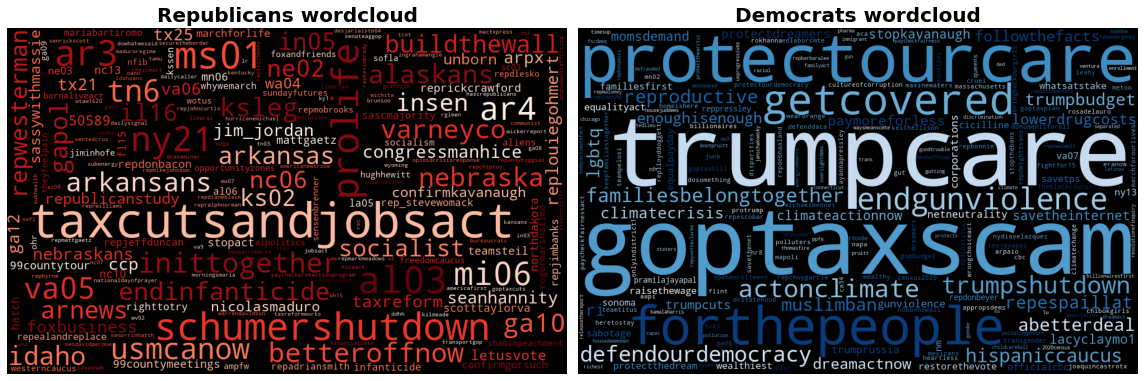

In [18]:
# Initialize plot
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize = (16,20))

# DC cloud
word_cloud_republican = wordcloud.WordCloud(
    colormap = 'Reds',
    background_color = 'black',
    random_state = 2,
    width = 1000,
    height = 618
)
word_cloud_republican.generate_from_frequencies(TF_TR_republican)
plt.subplot(1, 2, 1)
plt.imshow(word_cloud_republican)
plt.axis('off')
plt.title('Republicans wordcloud', fontsize = 20, fontweight='bold')

# Marvel cloud
word_cloud_democrat = wordcloud.WordCloud(
    colormap = 'Blues',
    background_color = 'black',
    random_state = 2,
    width = 1000,
    height = 618
)
word_cloud_democrat.generate_from_frequencies(TF_TR_democrat)

# Plot them side by side
plt.subplot(1, 2, 2)
plt.imshow(word_cloud_democrat)
plt.axis('off')
plt.title('Democrats wordcloud', fontsize = 20, fontweight='bold')

plt.show()